In [57]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from copy import deepcopy
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.model.real.vocalic import VocalicModel
from coordination.model.config_bundle.vocalic import VocalicConfigBundle

# Style

In [59]:
sns.set_style("white")
tex_fonts = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlesize": 8,
    "axes.linewidth": 1
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

DOC_WIDTH = 400

## Helper functions

In [60]:
def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

# Constants

In [61]:
# Plot
COLORS_SPR = ["#137513", "#FF9090", "#13B2FF"]
COLORS_CONV = ["#13B2FF", "#FF9090", "#137513"]
MUSTARD = "#BE9700"

# Reproducibility
SEED = 0

# Data 
T=100
BURN_IN = 2000
NUM_SAMPLES = 2000
NUM_CHAINS = 4

# Models

In [77]:
# Config bundle for a model of vocalics with two features
def get_config_bundle(num_time_steps, coordination, constant_coordination, process_noise = 0, observation_noise = 0):
    bundle = VocalicConfigBundle()
    bundle.num_vocalic_features = 2
    bundle.state_space_dimension_size = 2
    bundle.state_space_dimension_names = ["Latent Feature 1", "Latent Feature 2"]
    bundle.vocalic_feature_names = ["Feature 1", "Feature 2"]
    bundle.sd_a = process_noise
    bundle.sd_o = observation_noise
    bundle.mean_uc0 = 0.0
    bundle.sd_uc = 1.0
    bundle.match_vocalic_scale = False
    bundle.share_mean_a0_across_subjects = False
    bundle.share_mean_a0_across_dimensions = False
    bundle.weights = [np.array([[1, 0], [0, 5]])] # different scale per feature
    bundle.mean_a0 = np.array([[0,0], [2.5,2.5], [5,5]])  # Start at different positions and with different speeds

    # Fix coordination samples so we can generate samples for a fixed coordination series.
    if constant_coordination:
        bundle.constant_coordination = True
        bundle.initial_coordination_samples = np.ones((1, num_time_steps)) * coordination
    else:
        if isinstance(coordination, np.ndarray):
            coordination_series = coordination
        else:
            coordination_series = np.ones(num_time_steps) * coordination
        bundle.initial_coordination_samples = coordination_series[None, :]

    return bundle


model_no_c = VocalicModel(get_config_bundle(T, 0, False, process_noise = 0, observation_noise = 0))
model_half_c = VocalicModel(get_config_bundle(T, 0.5, False, process_noise = 0, observation_noise = 0))
model_full_c = VocalicModel(get_config_bundle(T, 0.8, False, process_noise = 0, observation_noise = 0))

# Synthetic Data

## Helper Functions

In [70]:
def plot_spring_data(ax: Any, data: np.ndarray, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    num_time_steps = data.shape[-1]
    
    tt = np.arange(num_time_steps)
    
    for s in range(NUM_SPRINGS):        
        ax.plot(tt, y_shift_fn(data[s, 0],s), label=f"Spring {s + 1}", color=COLORS_SPR[s], linewidth=line_width, linestyle='solid')
        
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def plot_conversation_data(ax: Any, data: conversationSeries, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    for s, name in enumerate(SUBJECT_NAMES):
        tt = np.array([t for t, subject in enumerate(data.subjects_in_time) if s == subject])
        ax.plot(tt, y_shift_fn(data.observation[0, tt],s), label=name, color=COLORS_CONV[s], linewidth=line_width, linestyle='solid')
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def conversation_samples_to_evidence(samples: SerialconversationSamples) -> SerialconversationSeries:
    return ConversationSeries(subjects_in_time=samples.state.subjects[0],
                              prev_time_same_subject=samples.state.prev_time_same_subject[0],
                              prev_time_diff_subject=samples.state.prev_time_diff_subject[0],
                              observation=samples.observation.values[0])   

def plot_observations(samples, ax, dim = 0, dim_name = "Pitch"):
    time_map = samples.component_group_samples["state_space"].time_steps_in_coordination_scale[0]
    subject_indices = samples.component_group_samples["speech_vocalics"].subject_indices[0]
    values = samples.component_group_samples["speech_vocalics"].values[0]
    for subject in range(3):
        ts_idx = np.array([t for t, s in enumerate(subject_indices) if s == subject])
        ts = np.array([time_map[t] for t in ts_idx])
        ys = values[dim, ts_idx]
        ax.plot(ts, ys, label=f"Subject {subject + 1}", marker="o", markersize=5, linestyle="--", linewidth=0.5)   
        ax.set_xlabel("Time Step")
        ax.set_ylabel(dim_name)

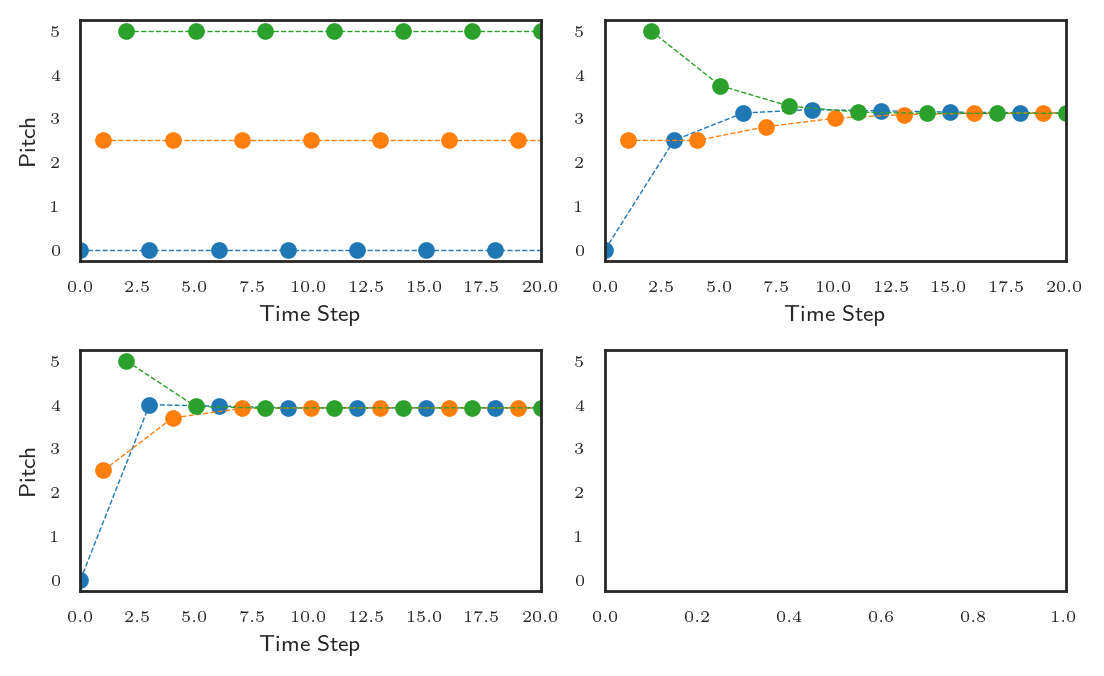

In [71]:
# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,2))  
fig, axs = plt.subplots(2, 2, figsize=(w,h))
axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

x_slice = [0, 20]

data_no_c = model_no_c.draw_samples()
data_half_c = model_half_c.draw_samples()
data_full_c = model_full_c.draw_samples()

plot_observations(data_no_c, axs[0, 0])
plot_observations(data_half_c, axs[0, 1])
plot_observations(data_full_c, axs[1, 0])

axs[0,0].set_xlim(x_slice)
axs[0,1].set_xlim(x_slice)
axs[1,0].set_xlim(x_slice)
axs[0,1].set_ylabel("")
plt.tight_layout()

# Experiments

## Helper Functions

In [107]:
def train(model, burn_in, num_samples, num_chains) -> InferenceData:
    # Clone the model so we can create new random variables for it.
    model.prepare_for_inference()    
    idata = model.fit(burn_in = burn_in, num_samples = num_samples, num_chains = num_chains)

    # Plot coordination
    w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1)  
    fig = plt.figure(figsize=(w,h))
    idata.plot_time_series_posterior(ax=fig.gca(), variable_name="coordination", include_bands=True, value_bounds=(0, 1), marker=None)
    idata.plot_parameter_posterior()
    print(idata.generate_convergence_summary())
    return idata

def run_inference(model, process_noise=0.01, observation_noise=0.1, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, clear_vars=True):
    bundle = deepcopy(model.config_bundle)
    bundle.sd_a = process_noise
    bundle.sd_o = observation_noise
    bundle.observation_normalization = "norm_per_feature"
    bundle.sd_mean_uc0 = 5.0
    bundle.sd_sd_uc = 0.5
    cloned_model = type(model)(bundle)
    samples = cloned_model.draw_samples()
    update_config_bundle_from_samples(cloned_model.config_bundle, samples)

    if clear_vars:
        bundle.mean_uc0=None
        bundle.sd_uc=None
        bundle.mean_a0=None
        bundle.sd_a=None
        bundle.sd_o=None
        # Because features are normalized, we can fix the weights to unitary scale
        cloned_model.config_bundle.weights = [np.ones((1,2))]  

    idata = train(cloned_model, burn_in, num_samples, num_chains)
    return idata, samples    

def update_config_bundle_from_samples(config_bundle, samples):
    # Metadata
    config_bundle.prev_time_diff_subject = samples.component_group_samples["state_space"].prev_time_diff_subject[0]
    config_bundle.prev_time_same_subject = samples.component_group_samples["state_space"].prev_time_same_subject[0]
    config_bundle.subject_indices = samples.component_group_samples["speech_vocalics"].subject_indices[0]
    config_bundle.time_steps_in_coordination_scale = samples.component_group_samples["speech_vocalics"].time_steps_in_coordination_scale[0]

    # Data
    config_bundle.observed_values = samples.component_group_samples["speech_vocalics"].values[0]

# Inference

## C = 0

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]
INFO:pymc:NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1572 seconds.
INFO:pymc:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1572 seconds.


[['coordination_mean_uc0', 'yes', 1.0083440780186304, 0.0], ['unbounded_coordination', 'yes', 1.0315843891540633, 0.010992704018331027], ['state_space_mean_a0', 'yes', 1.009578727230252, 0.003200544573446891], ['state_space', 'yes', 1.006559998034427, 0.0052568140483780544], ['coordination_sd_uc', 'yes', 1.0857491801355477, 0.0], ['state_space_sd_a', 'yes', 1.084296013770956, 0.0], ['speech_vocalics_sd_o', 'yes', 1.009568791428016, 0.0], ['coordination', 'yes', 1.0315695367897646, 0.011031567116038093]]
                 variable converged  mean_rhat  std_rhat
0   coordination_mean_uc0       yes   1.008344  0.000000
1  unbounded_coordination       yes   1.031584  0.010993
2     state_space_mean_a0       yes   1.009579  0.003201
3             state_space       yes   1.006560  0.005257
4      coordination_sd_uc       yes   1.085749  0.000000
5        state_space_sd_a       yes   1.084296  0.000000
6    speech_vocalics_sd_o       yes   1.009569  0.000000
7            coordination       yes

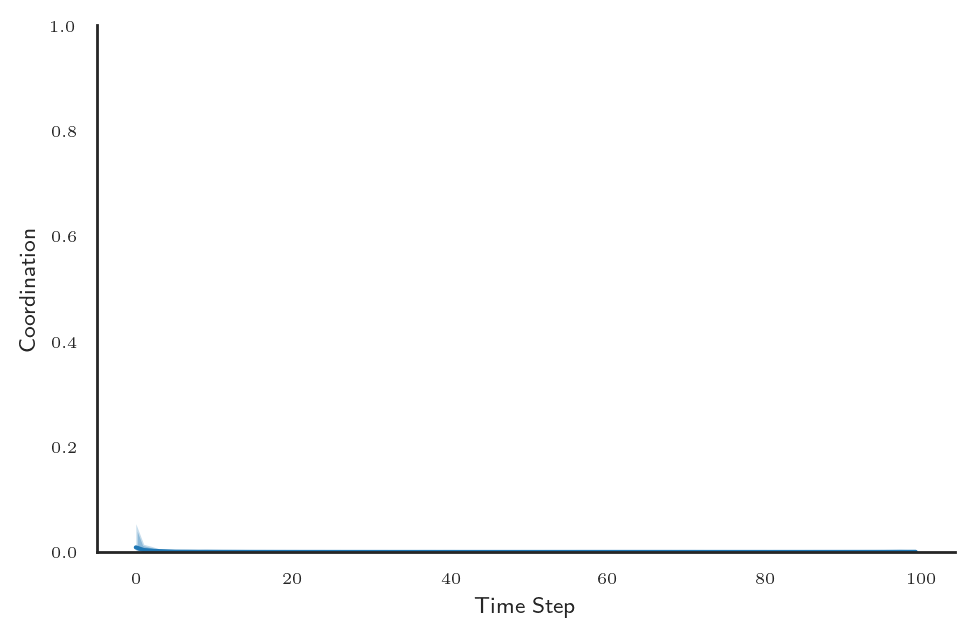

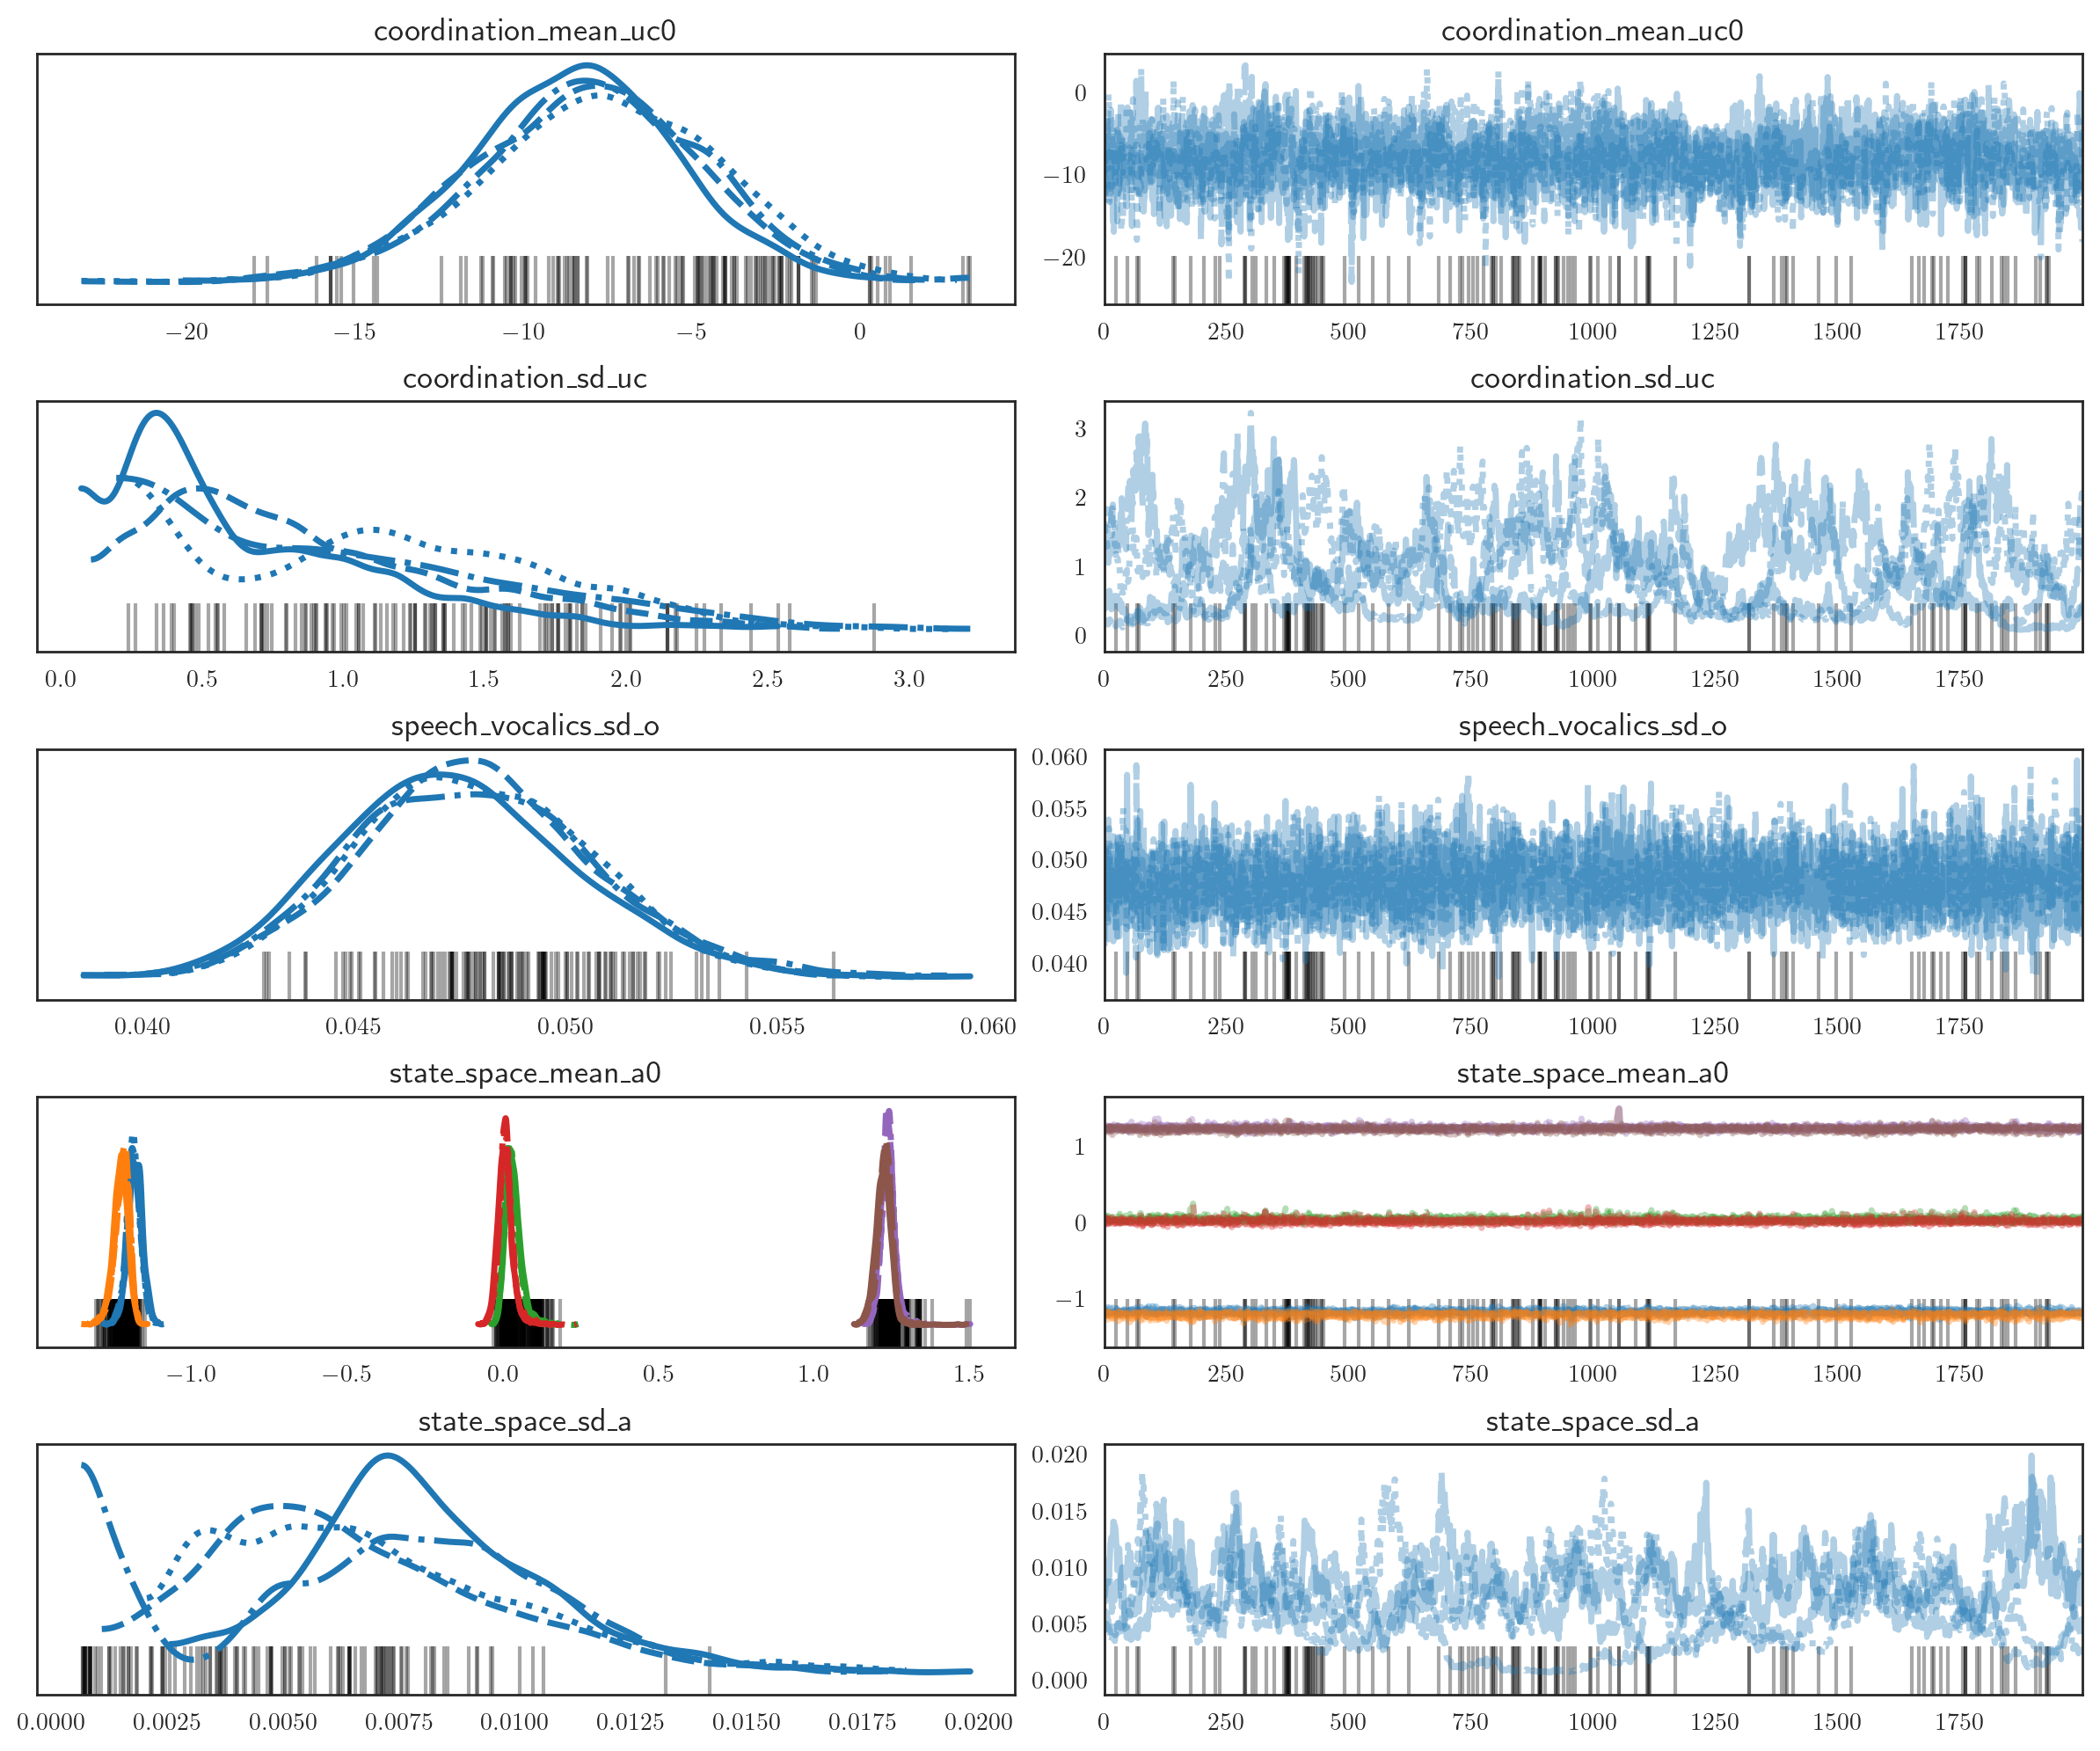

In [101]:
# idata_no_c = train(model_no_c, BURN_IN, NUM_SAMPLES, NUM_CHAINS)
idata_no_c, noisy_data_no_c = run_inference(model_no_c)

## C = 0.5

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]
INFO:pymc:NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 55 seconds.
INFO:pymc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 55 seconds.


[['coordination_mean_uc0', 'yes', 1.0894333229968878, 0.0], ['unbounded_coordination', 'no', 1.2356130880244407, 0.18099641192588004], ['state_space_mean_a0', 'yes', 1.0250286724239739, 0.022653338159936733], ['state_space', 'yes', 1.0201966817503438, 0.01966021851483586], ['coordination_sd_uc', 'no', 1.299359816754945, 0.0], ['state_space_sd_a', 'no', 1.416755945324596, 0.0], ['speech_vocalics_sd_o', 'yes', 1.0262710579664074, 0.0], ['coordination', 'no', 1.2343375163555559, 0.1821347787336695]]
                 variable converged  mean_rhat  std_rhat
0   coordination_mean_uc0       yes   1.089433  0.000000
1  unbounded_coordination        no   1.235613  0.180996
2     state_space_mean_a0       yes   1.025029  0.022653
3             state_space       yes   1.020197  0.019660
4      coordination_sd_uc        no   1.299360  0.000000
5        state_space_sd_a        no   1.416756  0.000000
6    speech_vocalics_sd_o       yes   1.026271  0.000000
7            coordination        no   1.23

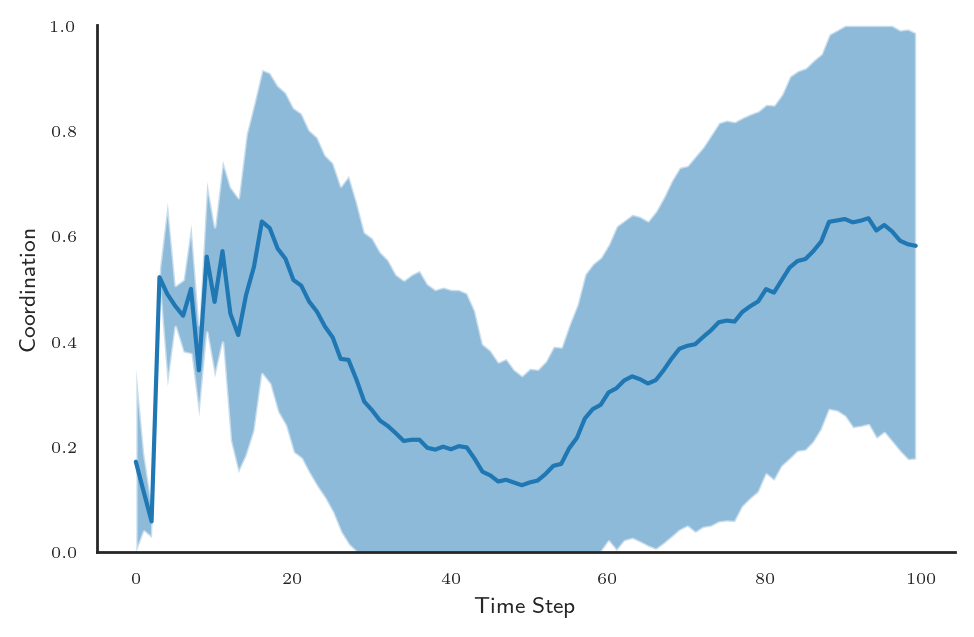

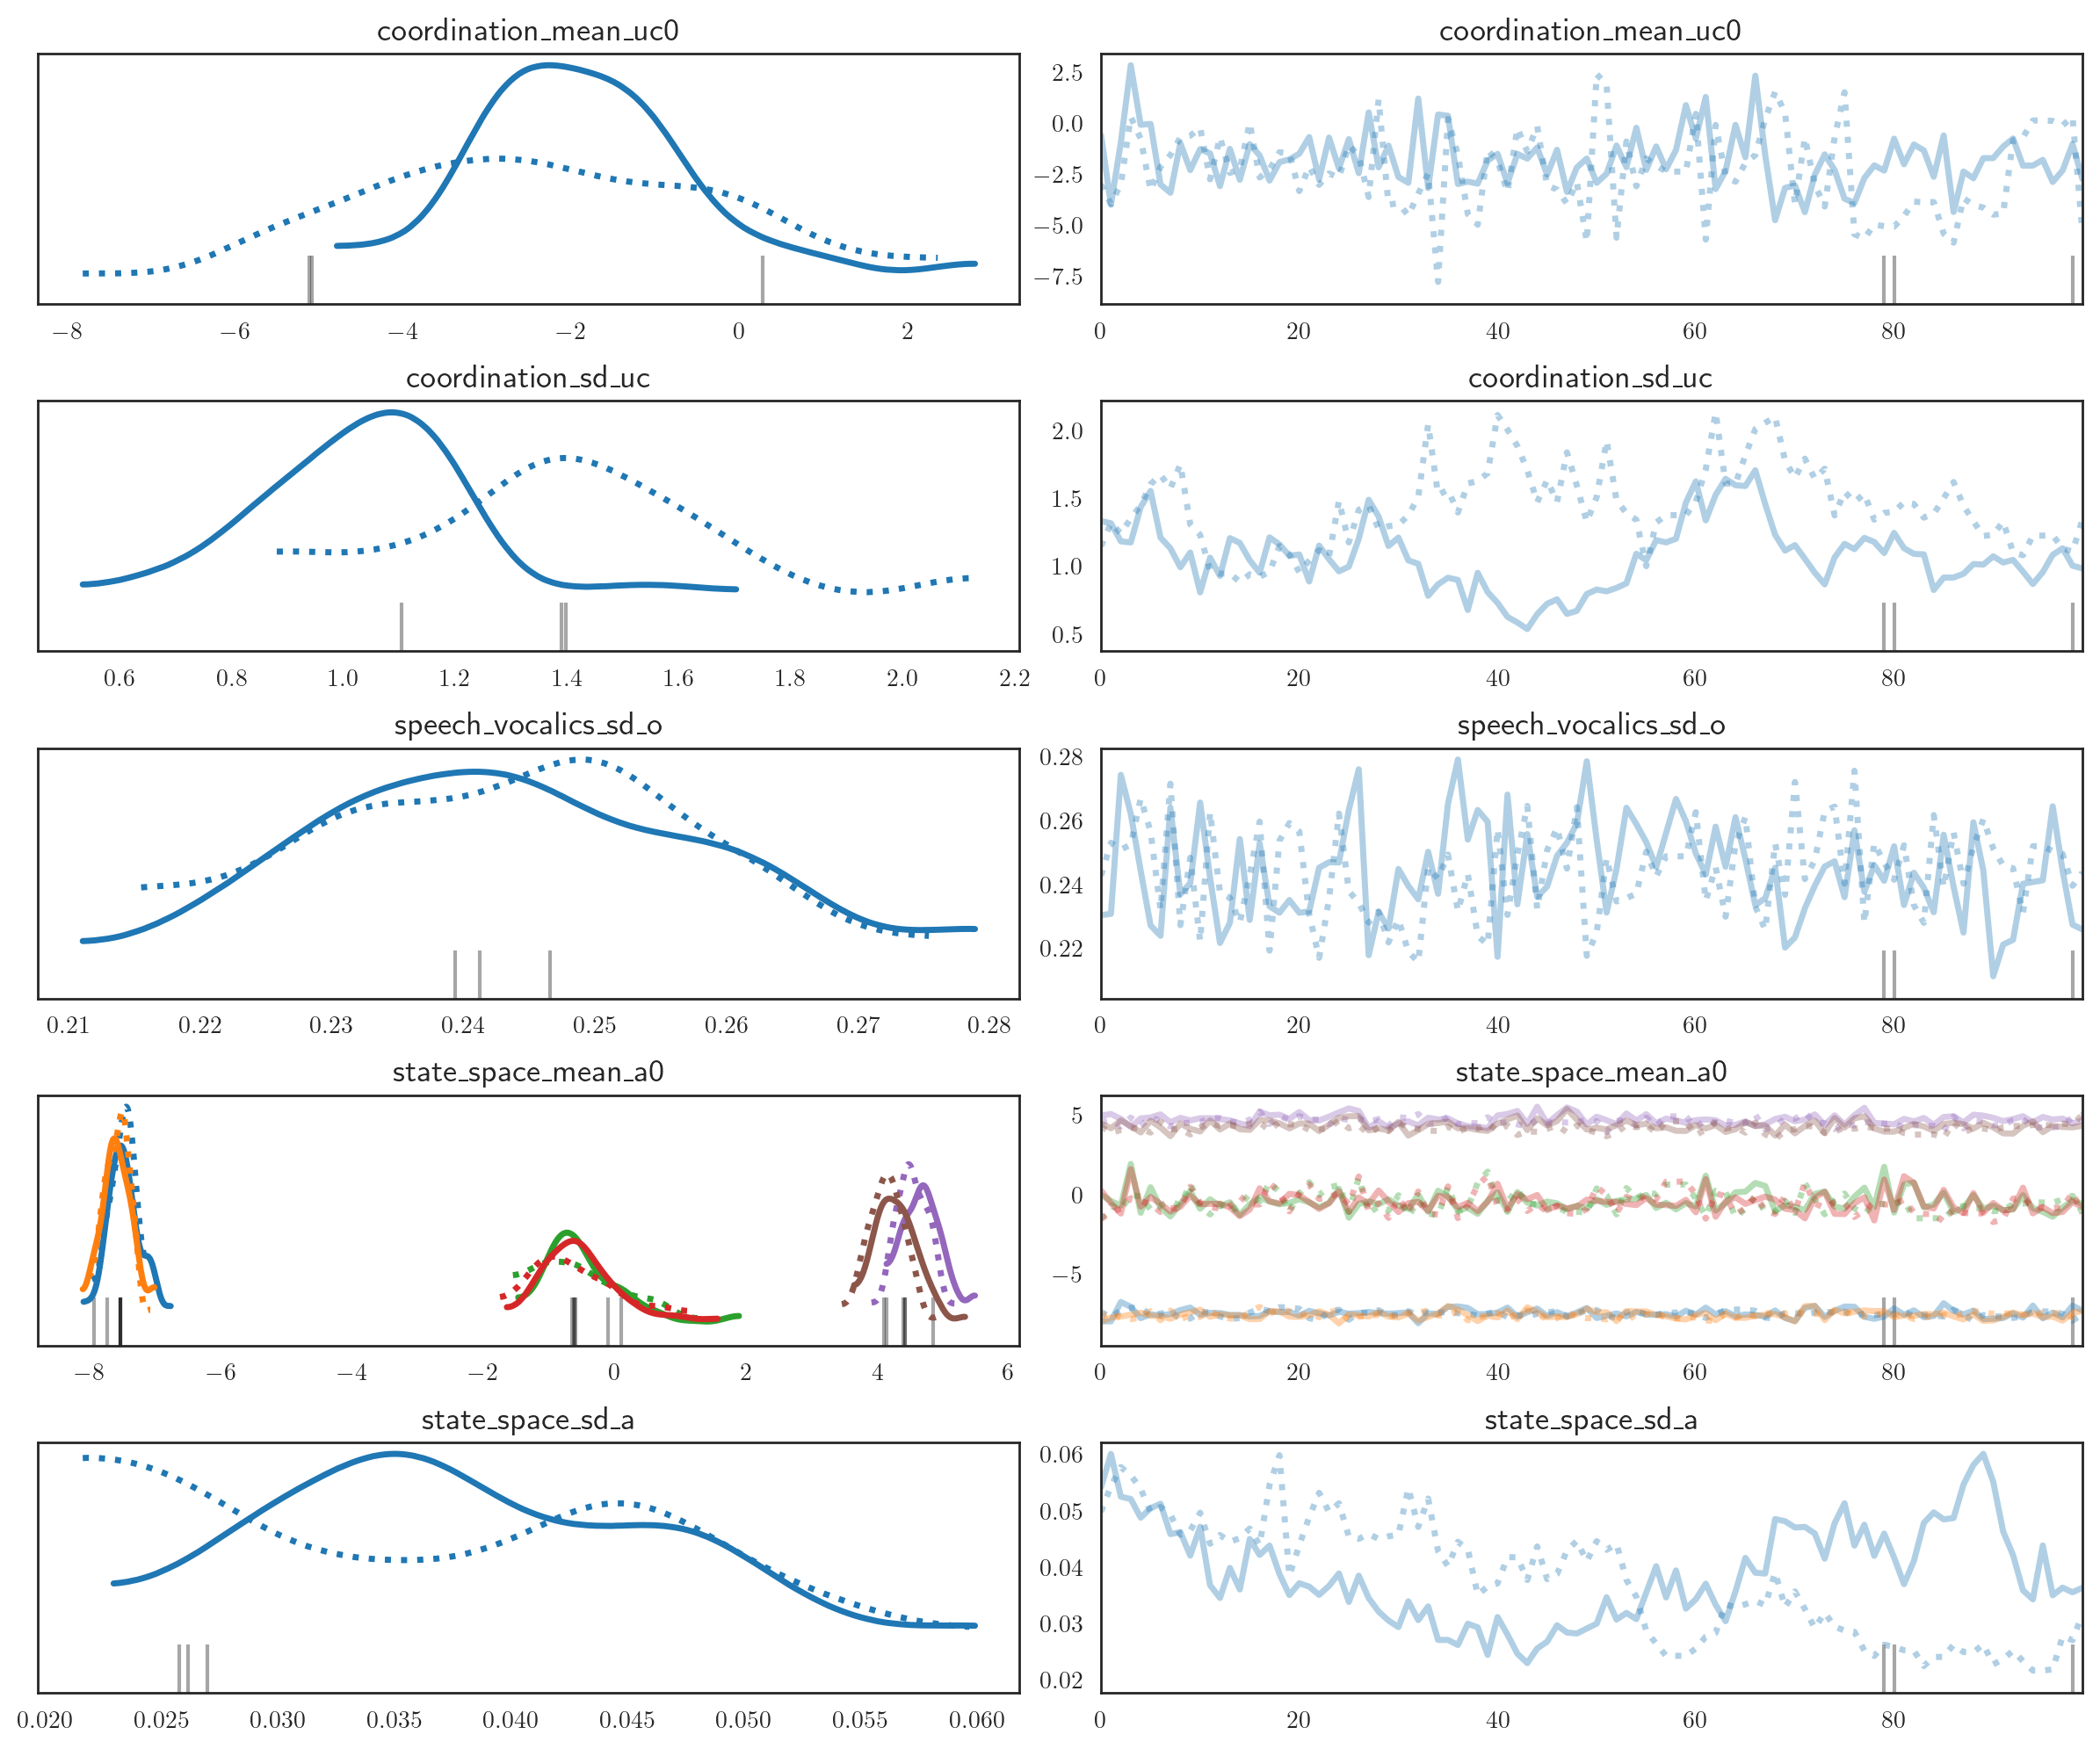

In [102]:
# idata_no_c = train(model_no_c, BURN_IN, NUM_SAMPLES, NUM_CHAINS)
idata_half_c, noisy_data_half_c = run_inference(model_half_c, burn_in=100, num_samples=100, num_chains=2)

## C = 0.8

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]
INFO:pymc:NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space_sd_a, state_space, speech_vocalics_sd_o]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 56 seconds.
INFO:pymc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 56 seconds.


[['coordination_mean_uc0', 'yes', 1.0337336816243374, 0.0], ['unbounded_coordination', 'no', 1.1938898768591923, 0.11258122152337173], ['state_space_mean_a0', 'yes', 1.0101463511040463, 0.011381999270165304], ['state_space', 'yes', 1.021251448565672, 0.022298962769203075], ['coordination_sd_uc', 'yes', 1.0847979398645362, 0.0], ['state_space_sd_a', 'no', 1.5273911424091242, 0.0], ['speech_vocalics_sd_o', 'yes', 1.015224366900216, 0.0], ['coordination', 'no', 1.1945364133183154, 0.11233888914171136]]
                 variable converged  mean_rhat  std_rhat
0   coordination_mean_uc0       yes   1.033734  0.000000
1  unbounded_coordination        no   1.193890  0.112581
2     state_space_mean_a0       yes   1.010146  0.011382
3             state_space       yes   1.021251  0.022299
4      coordination_sd_uc       yes   1.084798  0.000000
5        state_space_sd_a        no   1.527391  0.000000
6    speech_vocalics_sd_o       yes   1.015224  0.000000
7            coordination        no   1

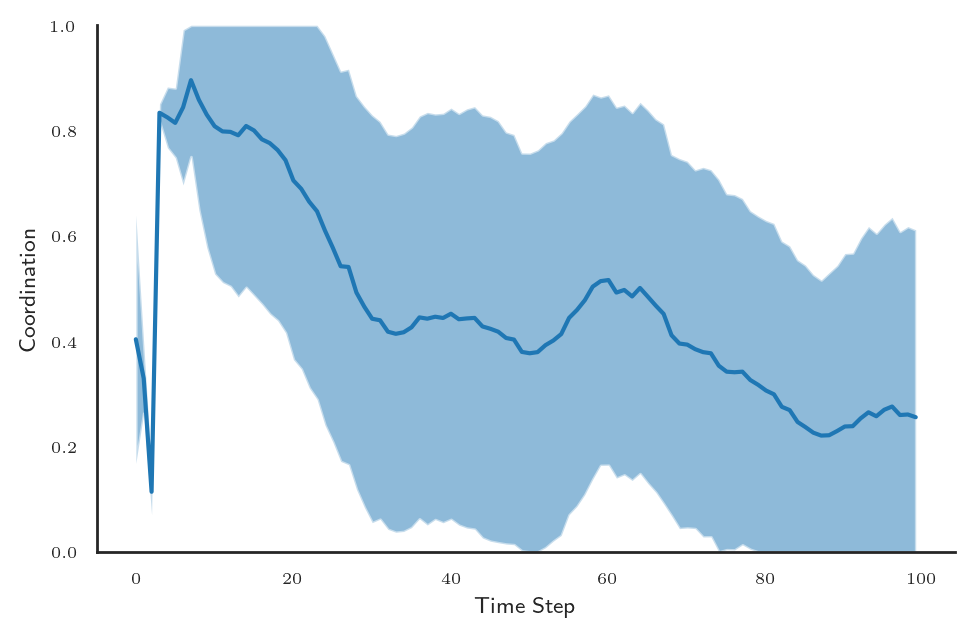

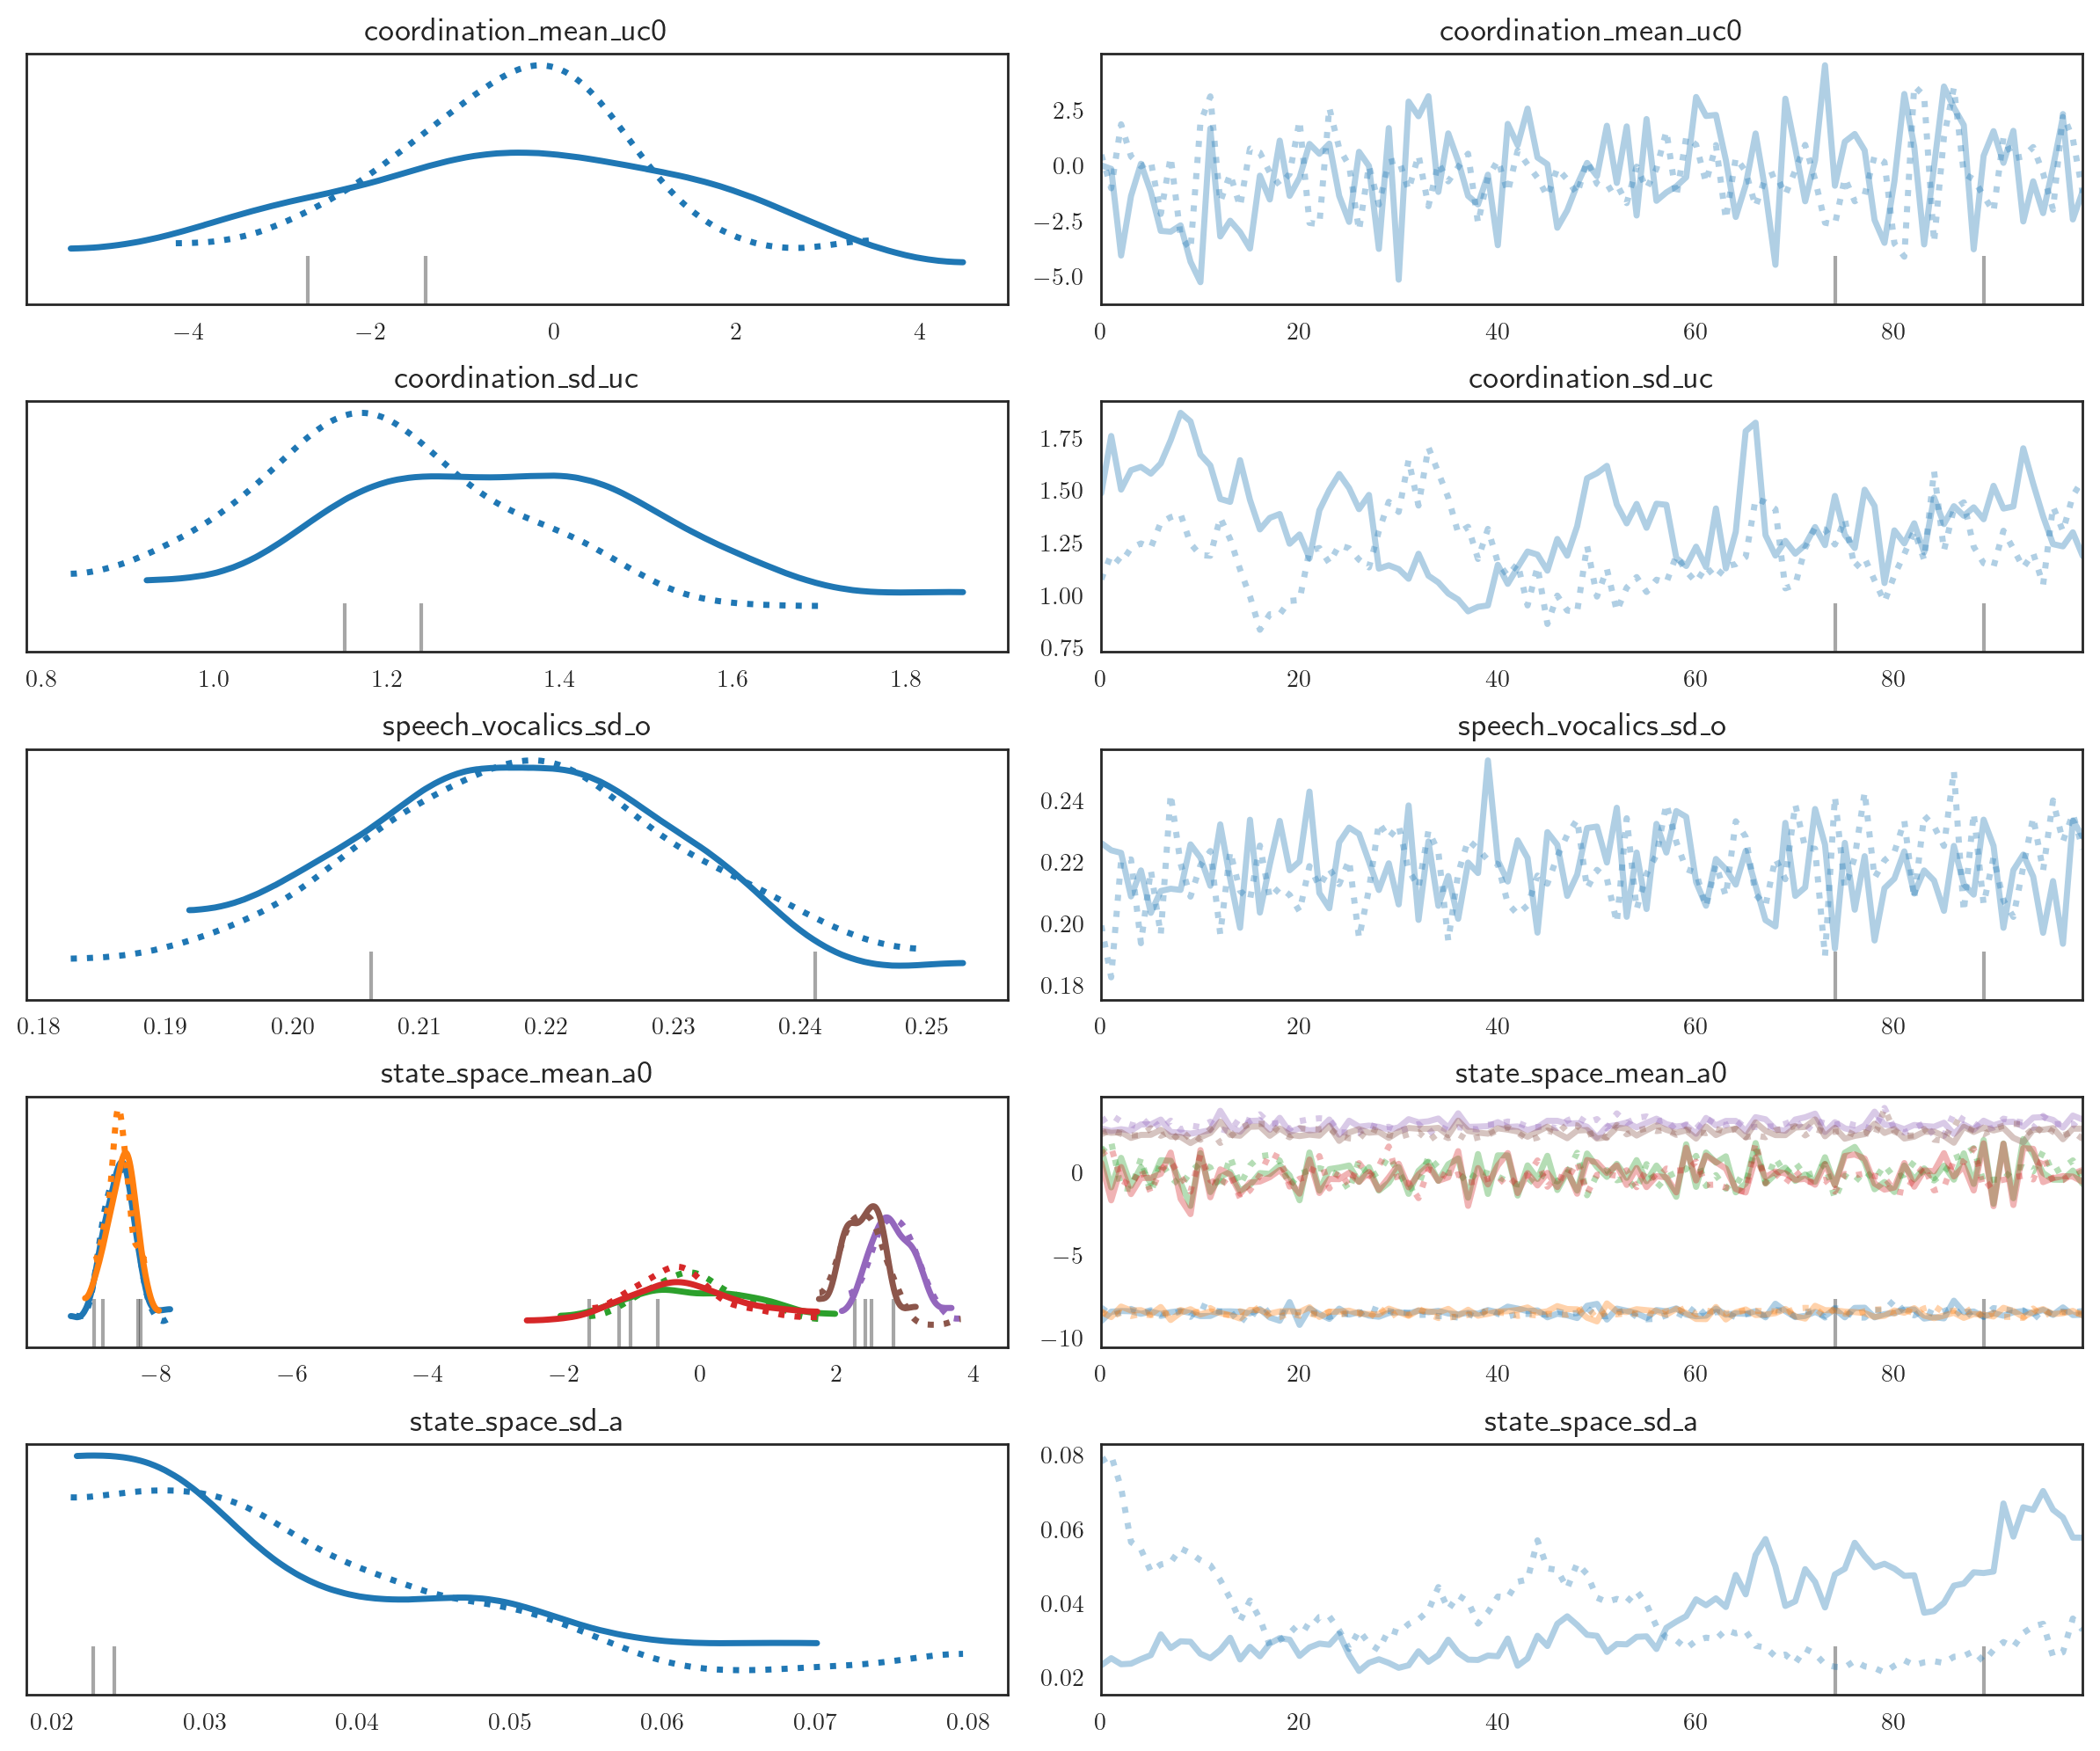

In [108]:
# idata_no_c = train(model_no_c, BURN_IN, NUM_SAMPLES, NUM_CHAINS)
idata_full_c, noisy_data_full_c = run_inference(model_full_c, burn_in=100, num_samples=100, num_chains=2)

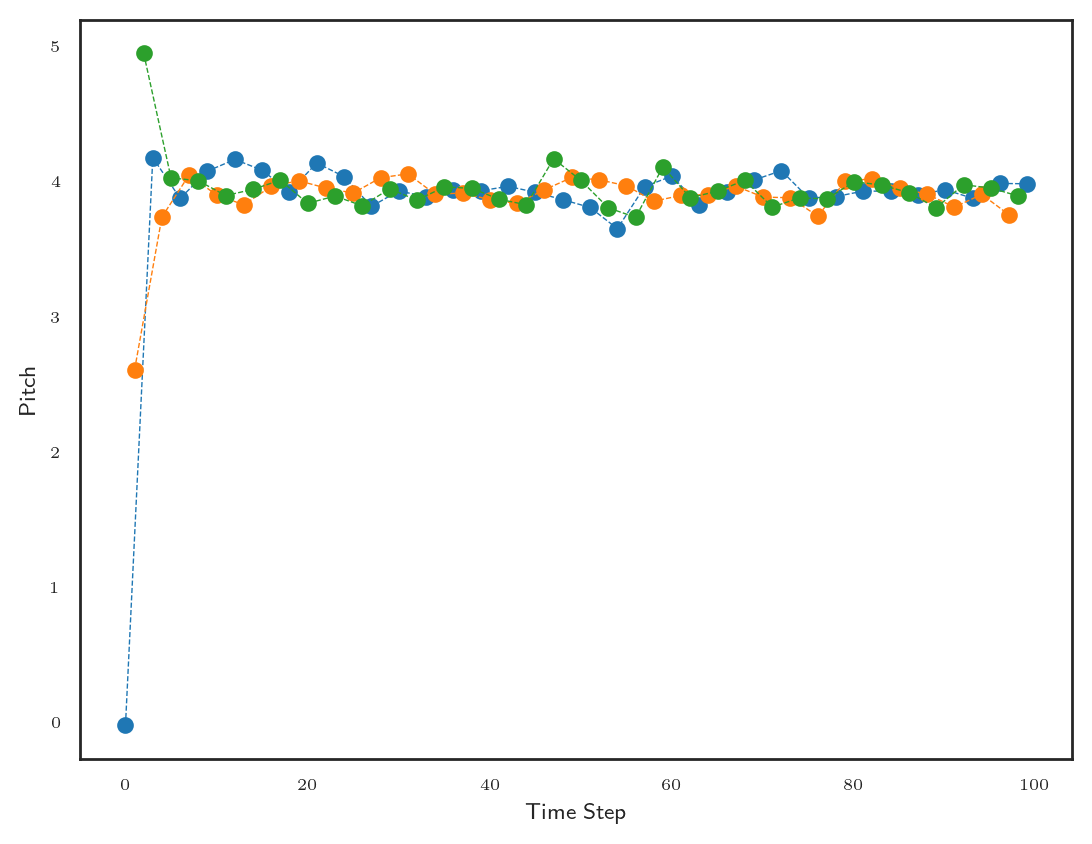

In [106]:
fig = plt.figure()
plot_observations(noisy_data_full_c, ax=fig.gca())

# Final Plot

In [86]:
def custom_formatter(x, pos):
    result = x
    if result == 0:
        return '0'
    # If not 0, format as multiples of 1000 (1K, 2K, 3K, etc.)
    return f'{result/1000:.1f}K'

def save_plot(image_name: str, fig: Any, format: str = "pdf"):
    fig.savefig(f"../assets/images/{image_name}.{format}", format=format, bbox_inches='tight', pad_inches=0)

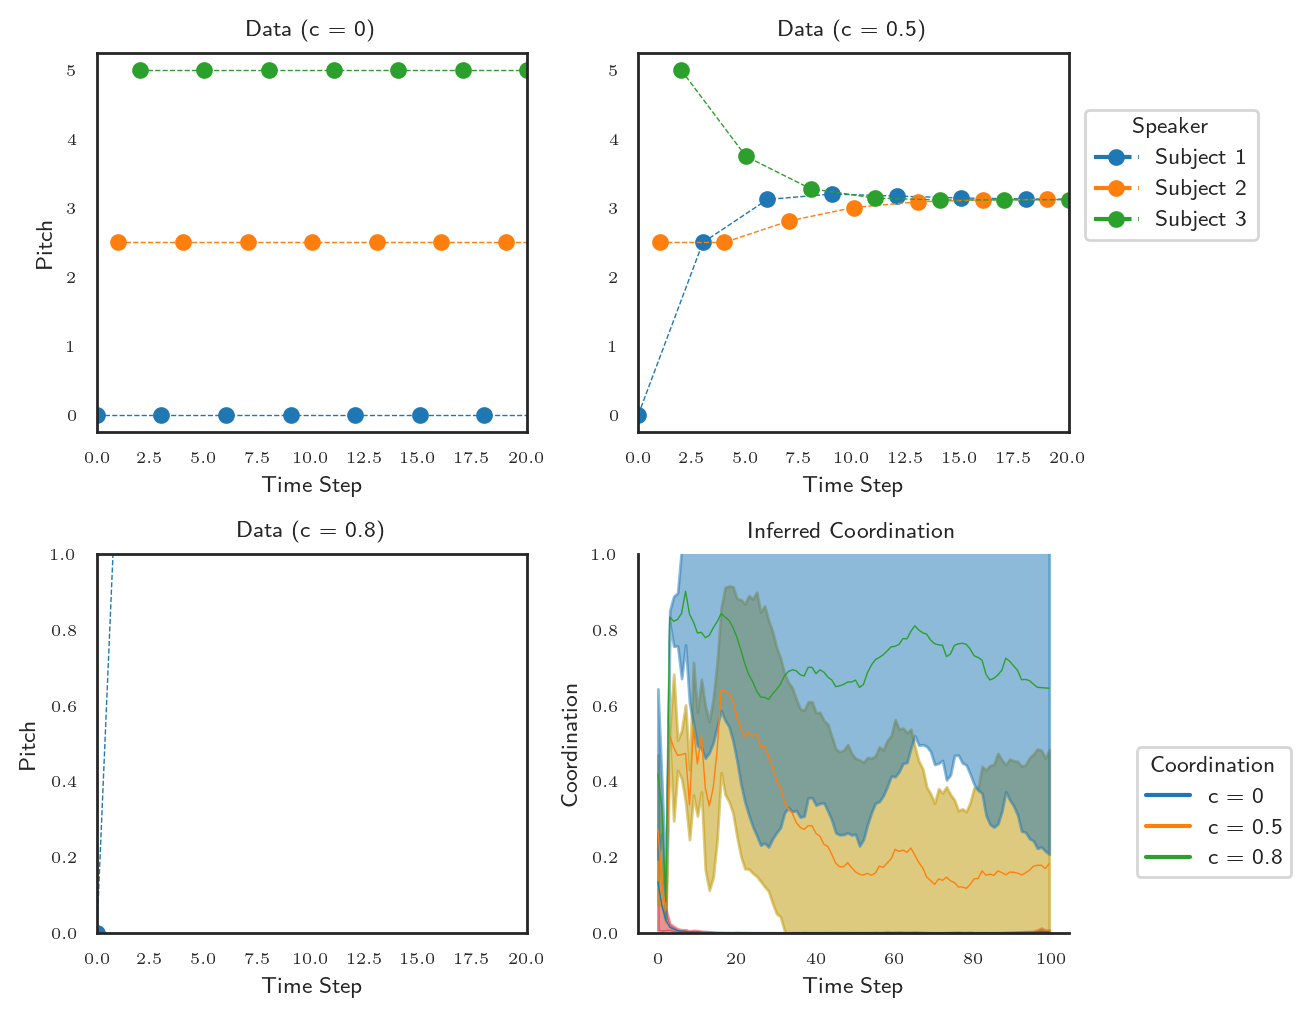

In [99]:
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1, subplots=(2,2))  
fig, axs = plt.subplots(2, 2, figsize=(w, h*1.5))

x_slice = [0, 20]

axs[0,1].sharey(axs[0,0])
axs[1,1].sharey(axs[1,0])

# Data plots
plot_observations(data_no_c, axs[0, 0])
axs[0,0].set_ylabel("Pitch")
axs[0,0].set_xlabel("Time Step")
axs[0,0].set_title("Data (c = 0)")
axs[0,0].set_xlim(x_slice)

plot_observations(data_half_c, axs[0, 1])
axs[0,1].set_ylabel("")
axs[0,1].set_xlabel("Time Step")
axs[0,1].set_title("Data (c = 0.5)")
axs[0,1].set_xlim(x_slice)

plot_observations(data_full_c, axs[1, 0])
axs[1,0].set_ylabel("Pitch")
axs[1,0].set_xlabel("Time Step")
axs[1,0].set_title("Data (c = 0.8)")
axs[1,0].set_xlim(x_slice)

idata_no_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=0.5, color="tab:red", label="c = 0")
idata_half_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=0.5, color=MUSTARD, label="c = 0.5")
idata_full_c.plot_time_series_posterior("coordination", True, ax=axs[1,1], marker=None, linewidth=0.5, color="tab:blue", label="c = 0.8")
axs[1,1].set_title("Inferred Coordination")
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("Coordination")
axs[1,1].set_xlabel("Time Step")
axs[1,1].set_ylim([0,1])
sns.despine(ax=axs[1,1])

handles, labels = axs[0,0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=[1.15, 0.9], frameon=True, markerscale=1, columnspacing=1.4, title="Speaker")
for line in leg.get_lines():
    line.set_linewidth(1.5)

handles, labels = axs[1,1].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower right', ncol=1, bbox_to_anchor=[1.18, 0.13], frameon=True, markerscale=1, columnspacing=1.4, title="Coordination")
for line in leg.get_lines():
    line.set_linewidth(1.5)

plt.tight_layout()
# save_plot("results_conversation_model", fig, "png")
# save_plot("results_conversation_model", fig, "pdf")